In [1]:
import os
import sys

import scipy
import random
import numpy as np
import pandas as pd
from tqdm import tqdm
from collections import defaultdict
import warnings

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
%matplotlib inline
%reload_ext autoreload
%autoreload 2
%aimport
warnings.filterwarnings('ignore')
os.environ['MOMAPS_HOME'] = '/home/labs/hornsteinlab/Collaboration/MOmaps_Noam/MOmaps'
sys.path.insert(1, os.getenv('MOMAPS_HOME'))
from src.common.configs.base_config import BaseConfig


Modules to reload:
all-except-skipped

Modules to skip:



In [2]:
dists = pd.read_csv("/home/labs/hornsteinlab/Collaboration/MOmaps/outputs/models_outputs_deltaNLS_tl_neuroself_sep_TDP43/distances/deltaNLS/vqvec2/between_cell_lines_conds_similarities_rep_new.csv")


In [3]:
marker_to_organelle = BaseConfig().UMAP_MAPPINGS_MARKERS

marker_to_organelle['TDP43B'] = {'alias': marker_to_organelle['TDP43']['alias']+" 1", 'color': marker_to_organelle['TDP43']['color']}
marker_to_organelle['TDP43N'] = {'alias': marker_to_organelle['TDP43']['alias']+" 2", 'color': marker_to_organelle['TDP43']['color']}

In [4]:
dists['organelle'] = dists['marker'].map(lambda x: marker_to_organelle.get(x, {}).get('alias'))

In [5]:
# for figure 4D: we want marker ranking comparing ***delatNLS*** line with and without induction.
dists_tdp = dists[dists.cell_line_condition == 'TDP43_Untreated'][['marker','batch','rep','TDP43_dox','organelle']].sort_values(by='marker')
dists_tdp = dists_tdp[~dists_tdp.marker.str.contains('KIF20A|KIFC1|Pericentrin|Rab5|Tubulin')] # remove unwanted markers

for name, group in dists_tdp.groupby(['batch','rep'])['TDP43_dox']:
    group_min = group.min()
    group_max = group.max()
    scaled_group = (group-group_min) / (group_max - group_min)
    dists_tdp.loc[group.index, 'TDP43_dox_scaled'] = scaled_group
dists_tdp.rename(columns={'marker':"Marker"}, inplace=True)
dists_tdp['batch_rep'] = dists_tdp['batch'] + '_' + dists_tdp['rep']
dists_tdp['z_score'] = None
dists_tdp

,Marker,batch,rep,TDP43_dox,organelle,TDP43_dox_scaled,batch_rep,z_score
0,ANXA11,batch2,rep1,3.353555,ANXA11 granules,0.110543,batch2_rep1,None
441,ANXA11,batch4,rep2,2.048202,ANXA11 granules,0.058483,batch4_rep2,None
354,ANXA11,batch4,rep1,2.824509,ANXA11 granules,0.215392,batch4_rep1,None
267,ANXA11,batch3,rep2,4.547193,ANXA11 granules,0.459229,batch3_rep2,None
616,ANXA11,batch5,rep2,3.361972,ANXA11 granules,0.131327,batch5_rep2,None
...,...,...,...,...,...,...,...,...
264,mitotracker,batch3,rep1,2.975237,Mitochondria,0.227918,batch3_rep1,None
177,mitotracker,batch2,rep2,2.980901,Mitochondria,0.076167,batch2_rep2,None
87,mitotracker,batch2,rep1,2.973975,Mitochondria,0.062049,batch2_rep1,None
613,mitotracker,batch5,rep1,3.803677,Mitochondria,0.219074,batch5_rep1,None


In [7]:
# For suppl panel in figure 4, we want marker ranking comparing ***Wt and delatNLS*** line with induction.
dists_wt = dists[dists.cell_line_condition == 'WT_Untreated'][['marker','batch','rep','TDP43_dox','organelle']].sort_values(by='marker')
dists_wt = dists_wt[~dists_wt.marker.str.contains('KIF20A|KIFC1|Pericentrin|Rab5|Tubulin')] # remove unwanted markers

for name, group in dists_wt.groupby(['batch','rep'])['TDP43_dox']:
    group_min = group.min()
    group_max = group.max()
    scaled_group = (group-group_min) / (group_max - group_min)
    dists_wt.loc[group.index, 'TDP43_dox_scaled'] = scaled_group
dists_wt.rename(columns={'marker':"Marker"}, inplace=True)
dists_wt['batch_rep'] = dists_wt['batch'] + '_' + dists_wt['rep']
dists_wt['z_score'] = None

In [8]:
order_tdp = dists_tdp.groupby("organelle")['TDP43_dox_scaled'].mean().sort_values(ascending=False).index
order_wt = dists_wt.groupby("organelle")['TDP43_dox_scaled'].mean().sort_values(ascending=False).index


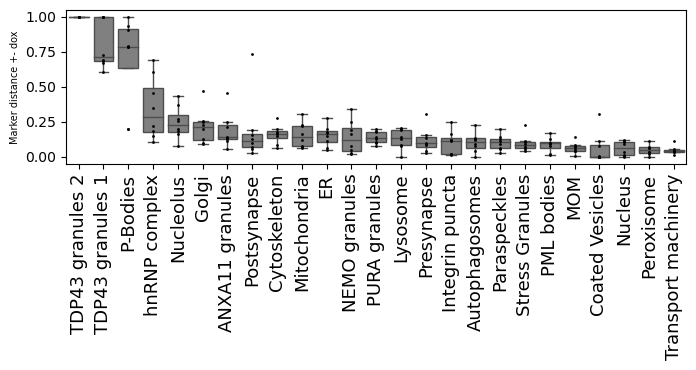

In [12]:
fig, ax = plt.subplots(figsize=(8,2))
# hue_palette = {'Replicate 1': 'gray', 'Replicate 2': 'lightgray'}
sns.stripplot(data=dists_tdp, x='organelle', y='TDP43_dox_scaled', color='black',
              order=order_tdp,dodge=True,size=2, jitter=0, marker='o', ax=ax, edgecolor='k',legend=False) 
sns.boxplot(data=dists_tdp,x='organelle',y='TDP43_dox_scaled' ,ax=ax,fliersize=0,
               order=order_tdp, linewidth=1, color='gray') #
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, fontsize=13)
ax.set_xlabel('')
ax.set_ylabel('Marker distance +- dox', fontsize=7)
# plt.show()
plt.savefig('manuscript/fig4/distances.eps',dpi=300, bbox_inches='tight')

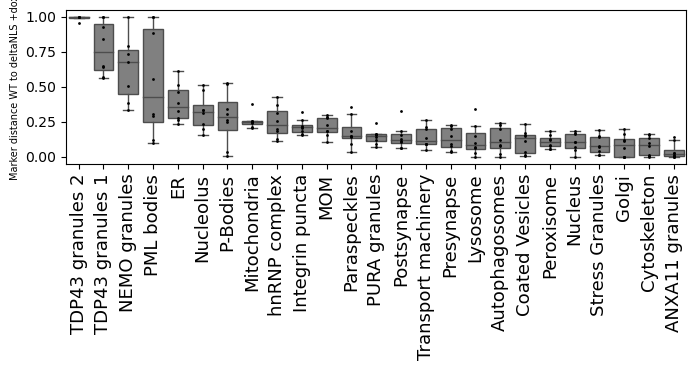

In [13]:
fig, ax = plt.subplots(figsize=(8,2))
# hue_palette = {'Replicate 1': 'gray', 'Replicate 2': 'lightgray'}
sns.stripplot(data=dists_wt, x='organelle', y='TDP43_dox_scaled', color='black',
              dodge=True, order=order_wt,size=2, jitter=0, marker='o', ax=ax, edgecolor='k',legend=False)
sns.boxplot(data=dists_wt,x='organelle',y='TDP43_dox_scaled' ,ax=ax,fliersize=0,
               order=order_wt,linewidth=1, color='gray') 
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, fontsize=13)
ax.set_xlabel('')
ax.set_ylabel('Marker distance WT to deltaNLS +dox', fontsize=7)
# plt.show()
plt.savefig('manuscript/sup_fig6/wt_tdp43dox_distances.eps',dpi=300, bbox_inches='tight')

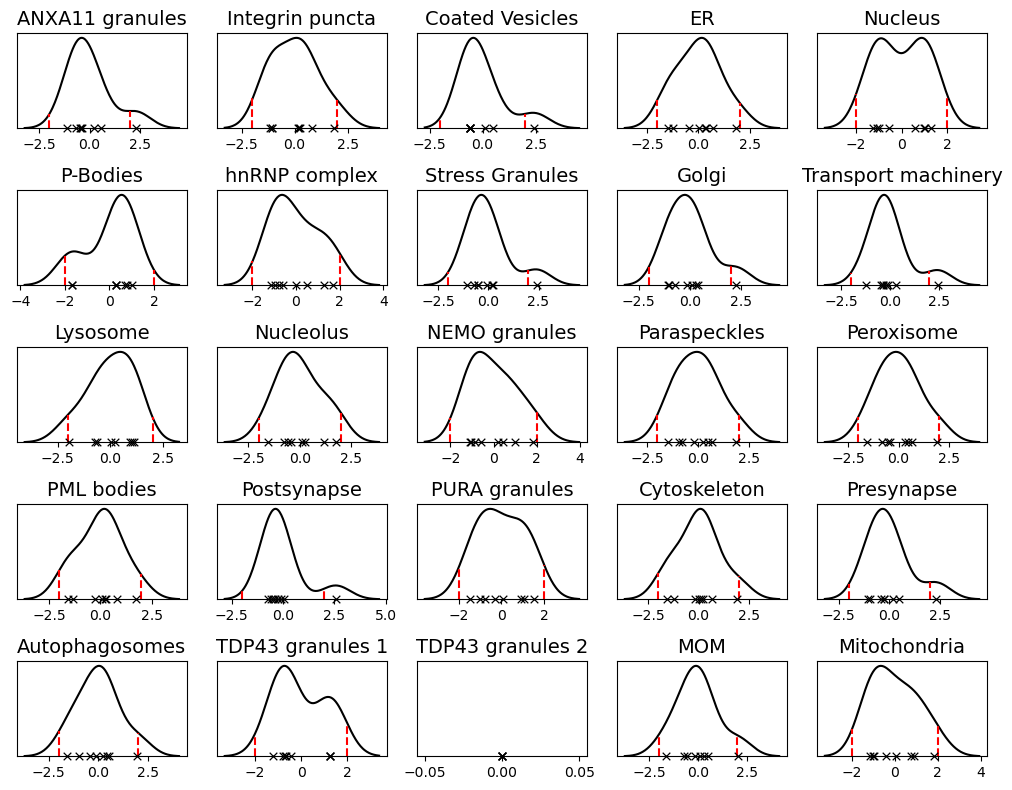

In [14]:
# normalization plots
nrows=5
ncols=5
fig, axs = plt.subplots(nrows,ncols, figsize=(10,8))
for i, (marker,marker_group) in enumerate(dists_tdp.groupby('Marker')):
    mean = np.mean(marker_group['TDP43_dox_scaled'])
    std_dev = np.std(marker_group['TDP43_dox_scaled'])
    z_scores = (marker_group['TDP43_dox_scaled'] - mean) / (std_dev if std_dev!=0 else 1)
    dists_tdp.loc[dists_tdp['Marker'] == marker, 'z_score'] = z_scores
    max_thres  = np.round(2*std_dev + mean,2)
    min_thres  = np.round(-2*std_dev + mean,2)

    # Sort the z-scores
    to_plot = dists_tdp[dists_tdp['Marker'] == marker][['z_score','batch_rep']]
    to_plot.sort_values(by='z_score')
    # to_plot['color'] = np.where(to_plot.batch_rep.str.contains(r'3|4|5', regex=True),'gray','black')    

    # Calculate the cumulative frequency
    cumulative_frequency = np.arange(1, len(to_plot) + 1) / len(to_plot)

    # Set a constant y value (e.g., 0)
    y_values = [0] * len(to_plot)

    # Create the plot
    ax = axs[i//ncols,i%ncols]
    ax.scatter(to_plot.z_score, y_values, color='black',
                          marker='x', zorder=10, clip_on=False, s=30, linewidths=0.9)
    ax.set_yticklabels([])
    ax.set_yticks([])
    
    if std_dev !=0 :
        kde = sns.kdeplot(to_plot.z_score, shade=False, color='black', label="Density", ax = ax)

        # Calculate the standard deviations from the mean
        std_deviation_values = [-2,2]  # Adjust this as needed
        for std_dev_value in std_deviation_values:
            std_dev_value = np.nanmean(to_plot.z_score) + std_dev_value * np.nanstd(to_plot.z_score)
            y_limit =kde.get_lines()[0].get_ydata()[np.abs(kde.get_lines()[0].get_xdata() -  std_dev_value).argmin()]
            ax.vlines(std_dev_value, ymin=0, ymax=y_limit, colors='r', linestyles='--')

    else:
        ax.set_ylim(0,1)
    # Add labels and legend
    ax.set_xlabel("")
    title = marker_to_organelle[marker]['alias']
    ax.set_title(title, fontsize=14)
    
    # ax.spines['top'].set_visible(False)
    # ax.spines['right'].set_visible(False)
    # legend_elements = [Line2D([0], [0], marker = 'x', color='black',linestyle='', label='Biological rep 2'),
    #                    Line2D([0], [0], marker='x', color='gray', linestyle='', label='Biological rep 1')]

    # ax.legend(handles=legend_elements, prop={'size': 6}, loc='upper right')
# axs[-1,-1].set_xlabel("z-score", fontsize=15)
# axs[-1,-1].set_ylabel("density",fontsize=15)
# # axs[-1,-1].set_xticklabels([])
# # axs[-1,-1].set_yticklabels([])
# axs[-1,-1].set_xticks([])
# axs[-1,-1].set_yticks([])
# axs[-1,-1].spines['top'].set_visible(False)
# axs[-1,-1].spines['right'].set_visible(False)
plt.tight_layout()
# plt.show()
plt.savefig('manuscript/sup_fig6/density_plots.eps',dpi=300, bbox_inches='tight')